In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
data_test = np.array(pd.read_csv('./emnist-letters-test.csv'))
data_train = np.array(pd.read_csv('./emnist-letters-train.csv'))

In [3]:
def vectorized_answer(i: int):
    v = np.zeros( (26, 1) )
    v[i - 1] = 1
    return v

def tidy_data(data):
    data_tidy = [(np.reshape(x[1:], (784, 1)), vectorized_answer(x[0])) for x in data]
    return data_tidy

data_test_list = tidy_data(data_test)
data_train_list = tidy_data(data_train)
a, b = data_test_list[0]
a.shape

(784, 1)

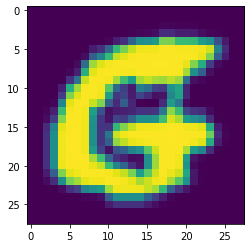

In [4]:
sample = data_train_list[0]
plt.imshow(np.reshape(sample[0], (28, 28)).T)

In [5]:
def sigmoid(x: np.double) -> np.double:
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x: np.double) -> np.double:
    """Производная сигмоидной функции."""
    a = sigmoid(x)
    return a * (1 - a)

In [6]:
class QuadraticCost:
    def fn(a, y):
        return 0.5 * np.linalg.norm(a - y)**2
    def delta(x, a, y):
        return (a - y) * sigmoid_prime(x)

In [9]:
class Network:
    def __init__(self, layer_sizes=[784,8,8,26]):
        self.layer_count = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.cost_function = QuadraticCost
        self.biases = [np.random.randn(y, 1) for y in self.layer_sizes[1:]]
        self.weights = [np.random.randn(y, x) / np.sqrt(x)
                        for x, y in zip(self.layer_sizes[:-1], self.layer_sizes[1:])]
    
    def SGD(self,
            data_train_list=data_train_list,
            data_test_list=data_test_list,
            epochs=1,
            n_batch=10,
            lr=3.0,
            reg = 0.0):
        n_train = len(data_train_list)
        n_test = len(data_test_list)
        for e in range(epochs):
            """
            В одной epoch можно использовать только 80% всех данных.
            """
            np.random.shuffle(data_train_list)
            r = range(0, int(n_train * 0.8), n_batch)
            batch_list = [ data_train_list[k:k+n_batch] for k in r ]
            for batch in batch_list:
                self.update_batch(batch=batch,
                                  lr=lr, # learning rate
                                  reg=reg,
                                  n_train=n_train,
                                  n_batch=n_batch)
    def update_batch(self, batch, lr, reg, n_train, n_batch):
        """
        Будем возвращать градиент функции затрат в виде 'grad_b' и 'grad_w'.
        """
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in batch:
            delta_grad_b, delta_grad_w = self.forward_backward_propagation(x, y)
            grad_b = [b+dgb for b, dgb in zip(grad_b, delta_grad_b)]
            grad_w = [w+dgw for w, dgw in zip(grad_w, delta_grad_w)]
        self.weights = [(1 - lr * (reg / n_train)) * w - (lr / n_batch) * gw for w, gw in zip(self.weights, grad_w)]
        self.biases = [b - (lr / n_batch) * gb for b, gb in zip(self.biases, grad_b)]

    def forward_backward_propagation(self, x, y):
        """
        Шагаем вперед.
        """
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        z_array = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            z_array.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        """
        Шагаем назад.
        """
        delta = self.cost_function.delta(z_array[-1], activations[-1], y)
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].T)
        
        for l in range(2, self.layer_count):
            sp = sigmoid_prime(z_array[-l])
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            grad_b[-l] = delta
            grad_w[-l] = np.dot(delta, activations[-l - 1].T)
        return (grad_b, grad_w)

net = Network()
net.SGD()

Weight dimensions:
W0: 784 x 8
W1: 8 x 8
W2: 8 x 26
Bias dimensions:
L1: 1 x 8
L2: 1 x 8
L3: 1 x 26


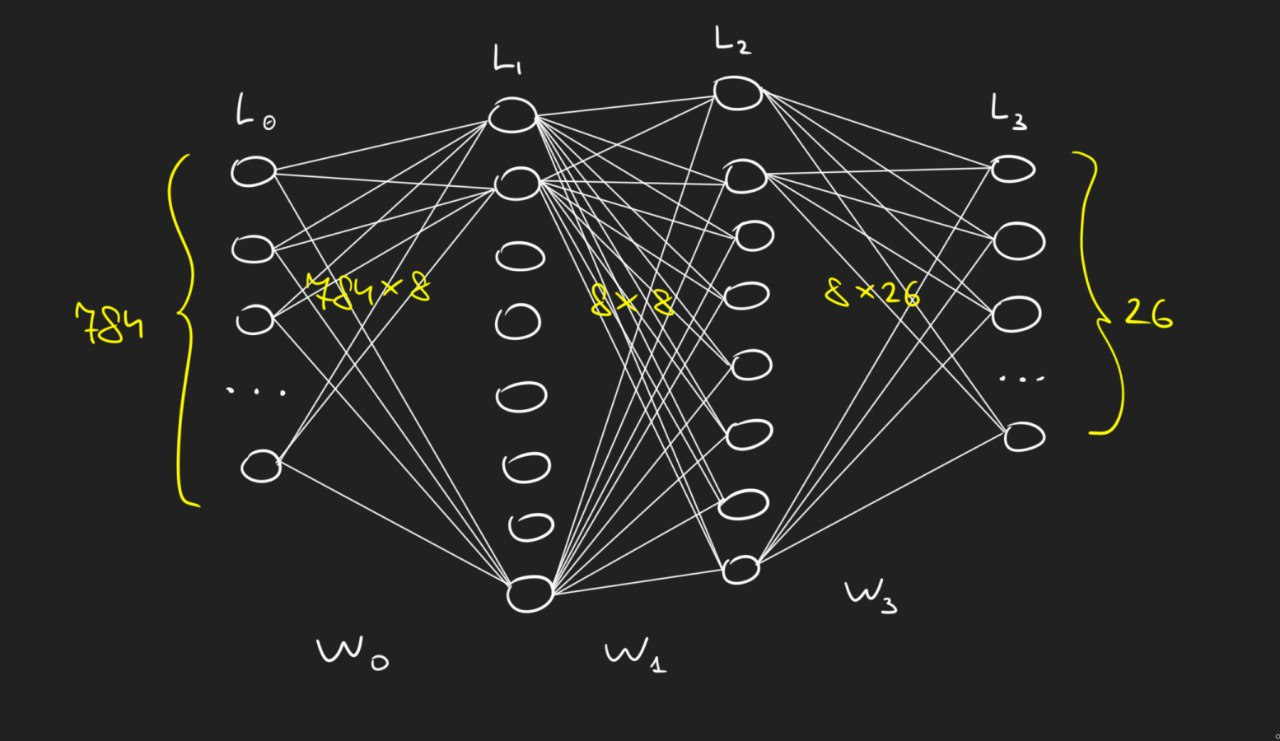

In [ ]:
print("Weight dimensions:")
for i, w in enumerate(net.weights):
    print( f"W{i}: {len(w[0])} x {len(w)}" )
"""
Смещение (bias) отсутствует в сенсорном слое.
"""
print("Bias dimensions:")
for i, b in enumerate(net.biases):
    print( f"L{i + 1}: {len(b[0])} x {len(b)}" )
Image(filename='./media/img0.jpg')